# Log Anomaly Detection with Calibrated Thresholds

This notebook implements production-ready anomaly detection:
1. **Load best fine-tuned model** (epoch 10) + OpenStack template vocabulary
2. **Calibrate thresholds** on validation set (normal windows):
   - Score = average NLL (or PPL) per window
   - Threshold = 99.5th percentile of normal validation scores
   - Hard rule: Flag windows with unseen-template rate > 5%
3. **Diagnostics**: Template coverage + positional entropy analysis
4. **Evaluation**: Apply thresholds to test set, compute precision/recall/F1

In [27]:
import json
import math
from pathlib import Path
from collections import defaultdict, Counter

import yaml
import pyarrow.parquet as pq
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid' if 'seaborn-v0_8-darkgrid' in plt.style.available else 'default')
%matplotlib inline

In [28]:
CWD = Path.cwd().resolve()
REPO_ROOT = CWD.parent if CWD.name == 'notebooks' else CWD

# Load OpenStack config
cfg = yaml.safe_load((REPO_ROOT / 'configs/train_openstack.yaml').read_text())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Model Architecture & Data Utils

In [29]:
class TemplateTransformer(nn.Module):
    def __init__(self, vocab_size: int, pad_id: int, d_model: int, n_layers: int, n_heads: int,
                 ffn_dim: int, dropout: float, max_length: int):
        super().__init__()
        self.pad_id = pad_id
        self.max_length = max_length
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.positional = nn.Parameter(torch.zeros(1, max_length, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=ffn_dim,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        self.output = nn.Linear(d_model, vocab_size)
        self.register_buffer('causal_mask', torch.triu(torch.ones(max_length, max_length), diagonal=1).bool(), persistent=False)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        seq_len = input_ids.size(1)
        x = self.embedding(input_ids)
        x = x + self.positional[:, :seq_len, :]
        causal = self.causal_mask[:seq_len, :seq_len]
        causal = causal.float().masked_fill(causal, float('-inf'))
        key_padding = attention_mask == 0
        x = self.encoder(x, mask=causal, src_key_padding_mask=key_padding)
        x = self.dropout(self.norm(x))
        logits = self.output(x)
        return logits

def read_sequences_with_labels(parquet_path: Path):
    """
    Read sequences and labels from parquet file.
    Tries to read 'label' column if present (from *_truth.parquet files),
    otherwise uses fallback method with anomaly_labels.txt mapping.
    """
    # Check if file has 'label' column by reading schema
    table = pq.read_table(parquet_path)
    has_label_col = 'label' in table.schema.names
    
    sequences = []
    labels = []
    session_ids = []
    
    if has_label_col:
        # Direct read from truth files (label column already present)
        for seq, label, sid in zip(
            table.column('templates').to_pylist(),
            table.column('label').to_pylist(),
            table.column('session_id').to_pylist()
        ):
            if seq and len(seq) > 1:
                sequences.append([int(x) for x in seq])
                labels.append(int(label) if label is not None else 0)
                session_ids.append(sid if sid else "")
    else:
        # Fallback: no label column, will need manual mapping
        for seq, sid in zip(
            table.column('templates').to_pylist(),
            table.column('session_id').to_pylist()
        ):
            if seq and len(seq) > 1:
                sequences.append([int(x) for x in seq])
                labels.append(0)  # Default to normal (caller will update)
                session_ids.append(sid if sid else "")
    
    return sequences, labels, session_ids, has_label_col

class TemplateSequenceDataset(Dataset):
    def __init__(self, sequences, labels=None):
        self.sequences = sequences
        self.labels = labels if labels is not None else [0] * len(sequences)
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

class TemplateBatchCollator:
    def __init__(self, pad_id: int, max_length: int):
        self.pad_id = pad_id
        self.max_length = max_length
    def __call__(self, batch):
        sequences, labels = zip(*batch)
        truncated = []
        kept_labels = []
        for seq, label in zip(sequences, labels):
            seq = seq[: self.max_length]
            if len(seq) < 2:
                continue
            truncated.append(seq)
            kept_labels.append(label)
        if not truncated:
            truncated = [sequences[0][: self.max_length]]
            kept_labels = [labels[0]]
        max_len = max(len(seq) for seq in truncated)
        input_len = max_len - 1
        bs = len(truncated)
        input_ids = torch.full((bs, input_len), self.pad_id, dtype=torch.long)
        target_ids = torch.full((bs, input_len), self.pad_id, dtype=torch.long)
        attention_mask = torch.zeros((bs, input_len), dtype=torch.long)
        for i, seq in enumerate(truncated):
            if len(seq) < 2:
                continue
            src = seq[:-1]
            tgt = seq[1:]
            input_ids[i, : len(src)] = torch.tensor(src, dtype=torch.long)
            target_ids[i, : len(tgt)] = torch.tensor(tgt, dtype=torch.long)
            attention_mask[i, : len(src)] = 1
        return {
            'input_ids': input_ids,
            'target_ids': target_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(kept_labels, dtype=torch.long)
        }

## Load Best Model & Vocabulary

In [30]:
# Load OpenStack vocabulary
data_cfg = cfg['data']
vocab_path = (REPO_ROOT / data_cfg['vocab_path']).resolve()
vocab = json.loads(vocab_path.read_text())
openstack_vocab_size = len(vocab.get('id_to_template', []))

pad_strategy = data_cfg.get('pad_token_strategy', 'vocab_size')
if pad_strategy == 'vocab_size':
    pad_id = openstack_vocab_size
    vocab_size = openstack_vocab_size + 1
else:
    pad_id = int(pad_strategy)
    vocab_size = max(openstack_vocab_size + 1, pad_id + 1)

max_seq_len = data_cfg.get('max_sequence_length', 100)

print("="*70)
print("MODEL & VOCABULARY CONFIGURATION")
print("="*70)
print(f"Vocabulary path:    {vocab_path}")
print(f"OpenStack templates: {openstack_vocab_size:,}")
print(f"Pad token ID:       {pad_id}")
print(f"Total vocab size:   {vocab_size:,}")
print(f"Max sequence length: {max_seq_len}")

# Create model
model_cfg = cfg['model']
model = TemplateTransformer(
    vocab_size=vocab_size,
    pad_id=pad_id,
    d_model=model_cfg['d_model'],
    n_layers=model_cfg['n_layers'],
    n_heads=model_cfg['n_heads'],
    ffn_dim=model_cfg['ffn_dim'],
    dropout=model_cfg['dropout'],
    max_length=max_seq_len,
).to(device)

# Load best checkpoint
checkpoint_dir = (REPO_ROOT / cfg['checkpointing']['output_dir']).resolve()
best_path = checkpoint_dir / 'best.pt'

print(f"\n{'='*70}")
print(f"LOADING BEST CHECKPOINT")
print(f"{'='*70}")
print(f"Path: {best_path}")

if best_path.exists():
    state = torch.load(best_path, map_location=device)
    model.load_state_dict(state['model_state_dict'])
    print(f"✓ Loaded checkpoint from epoch {state.get('epoch', 'N/A')}")
    print(f"  Val Loss: {state.get('val_loss', 'N/A'):.4f}" if state.get('val_loss') else "")
    print(f"  Val PPL:  {state.get('val_ppl', 'N/A'):.2f}" if state.get('val_ppl') else "")
else:
    raise FileNotFoundError(f"Best checkpoint not found: {best_path}")

model.eval()
print(f"{'='*70}\n")

MODEL & VOCABULARY CONFIGURATION
Vocabulary path:    /home/tpi/distil_shahreyar/artifacts/openstack_finetune/template_vocab.json
OpenStack templates: 158
Pad token ID:       158
Total vocab size:   159
Max sequence length: 100

LOADING BEST CHECKPOINT
Path: /home/tpi/distil_shahreyar/artifacts/openstack_finetune_model/best.pt
✓ Loaded checkpoint from epoch 10
  Val Loss: 0.2649
  Val PPL:  1.30



## Load Data with Labels

In [31]:
# Load sequences with labels
print("="*70)
print("LOADING DATA WITH LABELS")
print("="*70)

# Try to use *_truth.parquet files first (preferred - have label column from preprocessing)
val_file_path = (REPO_ROOT / data_cfg.get('val_truth_file', data_cfg['val_file'])).resolve()
test_file_path = (REPO_ROOT / data_cfg.get('test_truth_file', data_cfg['test_file'])).resolve()

# Fallback to regular files if truth files don't exist
if not val_file_path.exists():
    print(f"⚠ Truth file not found: {val_file_path}")
    val_file_path = (REPO_ROOT / data_cfg['val_file']).resolve()
    print(f"  Using fallback: {val_file_path}")

if not test_file_path.exists():
    print(f"⚠ Truth file not found: {test_file_path}")
    test_file_path = (REPO_ROOT / data_cfg['test_file']).resolve()
    print(f"  Using fallback: {test_file_path}")

print(f"\nData files:")
print(f"  Validation: {val_file_path.name}")
print(f"  Test:       {test_file_path.name}")

# Load sequences
val_sequences, val_labels, val_session_ids, val_has_labels = read_sequences_with_labels(val_file_path)
test_sequences, test_labels, test_session_ids, test_has_labels = read_sequences_with_labels(test_file_path)

print(f"\nDataset Sizes:")
print(f"  Validation: {len(val_sequences):,} sequences")
print(f"  Test:       {len(test_sequences):,} sequences")

# If files don't have label column, try UUID mapping (fallback method)
if not val_has_labels or not test_has_labels:
    print(f"\n⚠ Files missing 'label' column - trying UUID mapping fallback...")
    
    anomaly_session_ids = set()
    label_file = REPO_ROOT / 'data/openstack/raw/anomaly_labels.txt'
    
    if label_file.exists():
        print(f"📋 Loading anomaly labels from {label_file.name}...")
        with open(label_file, 'r') as f:
            for line in f:
                line = line.strip()
                # UUID pattern: 8-4-4-4-12 hex digits
                if len(line) == 36 and line.count('-') == 4:
                    anomaly_session_ids.add(line.lower())
        
        print(f"  Found {len(anomaly_session_ids):,} anomalous instance UUIDs")
        
        # Update labels based on session IDs (direct UUID match - won't work for req-IDs)
        val_anomalies = 0
        test_anomalies = 0
        
        for i, sid in enumerate(val_session_ids):
            if sid and sid.lower() in anomaly_session_ids:
                val_labels[i] = 1
                val_anomalies += 1
        
        for i, sid in enumerate(test_session_ids):
            if sid and sid.lower() in anomaly_session_ids:
                test_labels[i] = 1
                test_anomalies += 1
        
        print(f"  Matched {val_anomalies:,} anomalies in validation set")
        print(f"  Matched {test_anomalies:,} anomalies in test set")
        
        if val_anomalies == 0 and test_anomalies == 0:
            print(f"\n⚠ WARNING: 0 anomalies matched!")
            print("  This is expected if session_id uses req-IDs but anomaly_labels.txt has instance UUIDs")
            print("  → Run the label attachment cell in 00_prepare_data.ipynb to create *_truth.parquet files")
            print("  → Those files will have proper instance UUID → req-ID mapping")
    else:
        print(f"\n⚠ WARNING: Label file not found: {label_file}")
        print("  All sequences will be treated as normal (label=0)")
else:
    print(f"\n✓ Labels loaded from parquet files")

# Label distribution
val_label_counts = Counter(val_labels)
test_label_counts = Counter(test_labels)

print(f"\nValidation Label Distribution:")
print(f"  Normal (0):  {val_label_counts[0]:,} ({val_label_counts[0]/len(val_labels)*100:.1f}%)")
print(f"  Anomaly (1): {val_label_counts[1]:,} ({val_label_counts[1]/len(val_labels)*100:.1f}%)")

print(f"\nTest Label Distribution:")
print(f"  Normal (0):  {test_label_counts[0]:,} ({test_label_counts[0]/len(test_labels)*100:.1f}%)")
print(f"  Anomaly (1): {test_label_counts[1]:,} ({test_label_counts[1]/len(test_labels)*100:.1f}%)")

# Create dataloaders
collator = TemplateBatchCollator(pad_id=pad_id, max_length=max_seq_len)

val_loader = DataLoader(
    TemplateSequenceDataset(val_sequences, val_labels),
    batch_size=64,
    shuffle=False,
    collate_fn=collator
)

test_loader = DataLoader(
    TemplateSequenceDataset(test_sequences, test_labels),
    batch_size=64,
    shuffle=False,
    collate_fn=collator
)

print(f"\n{'='*70}")
print("✓ Dataloaders created")
print(f"{'='*70}\n")

LOADING DATA WITH LABELS

Data files:
  Validation: val_truth.parquet
  Test:       test_truth.parquet

Dataset Sizes:
  Validation: 879 sequences
  Test:       986 sequences

✓ Labels loaded from parquet files

Validation Label Distribution:
  Normal (0):  828 (94.2%)
  Anomaly (1): 51 (5.8%)

Test Label Distribution:
  Normal (0):  802 (81.3%)
  Anomaly (1): 184 (18.7%)

✓ Dataloaders created



## Anomaly Scoring Functions

In [32]:
def compute_window_scores(model, loader, vocab_size, pad_id, device):
    """
    Compute anomaly scores for each window/sequence.
    
    Returns:
        scores: List of (avg_nll, avg_ppl, unseen_rate) tuples
        labels: List of ground truth labels
    """
    model.eval()
    all_scores = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Computing scores", leave=False):
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            
            logits = model(input_ids, attention_mask)
            
            # Compute per-sequence scores
            for i in range(input_ids.size(0)):
                seq_logits = logits[i]  # (seq_len, vocab_size)
                seq_targets = target_ids[i]  # (seq_len,)
                seq_mask = attention_mask[i]  # (seq_len,)
                
                # Get valid positions (not padding)
                valid_mask = (seq_targets != pad_id) & (seq_mask == 1)
                if valid_mask.sum() == 0:
                    continue
                
                valid_logits = seq_logits[valid_mask]  # (num_valid, vocab_size)
                valid_targets = seq_targets[valid_mask]  # (num_valid,)
                
                # Compute NLL per position
                nll_per_pos = F.cross_entropy(valid_logits, valid_targets, reduction='none')
                
                # Average NLL for window
                avg_nll = nll_per_pos.mean().item()
                avg_ppl = math.exp(min(avg_nll, 50))  # Clamp for numerical stability
                
                # Unseen template rate (templates >= original vocab size)
                # Concatenate input and target to get full sequence
                full_seq = torch.cat([input_ids[i], target_ids[i, -1:]])  # Reconstruct original
                full_seq = full_seq[full_seq != pad_id]  # Remove padding
                unseen_count = (full_seq >= openstack_vocab_size).sum().item()
                unseen_rate = unseen_count / len(full_seq) if len(full_seq) > 0 else 0.0
                
                all_scores.append((avg_nll, avg_ppl, unseen_rate))
                all_labels.append(labels[i].item())
    
    return all_scores, all_labels

print("Defined anomaly scoring functions")

Defined anomaly scoring functions


## Threshold Calibration on Validation Set (Normal Windows)

THRESHOLD CALIBRATION ON VALIDATION SET


Computing scores:   0%|          | 0/14 [00:00<?, ?it/s]

/home/tpi/anaconda3/envs/log_anomaly/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(



Computed scores for 879 validation windows

Normal windows:   828
Anomaly windows:  51

CALIBRATING THRESHOLDS (on normal windows only)

NLL Threshold (99.5th percentile):  0.7664
PPL Threshold (99.5th percentile):  2.15
Unseen Rate Threshold (hard rule):  5.00%

Normal Window Statistics:
  Avg NLL:        0.1105 ± 0.1955
  Avg PPL:        1.15 ± 0.61
  Avg Unseen:     0.00% ± 0.00%

Anomaly Window Statistics (for reference):
  Avg NLL:        0.3448 ± 0.1104
  Avg PPL:        1.42 ± 0.17
  Avg Unseen:     0.00% ± 0.00%

✓ Saved threshold calibration plot

✓ Saved threshold calibration plot


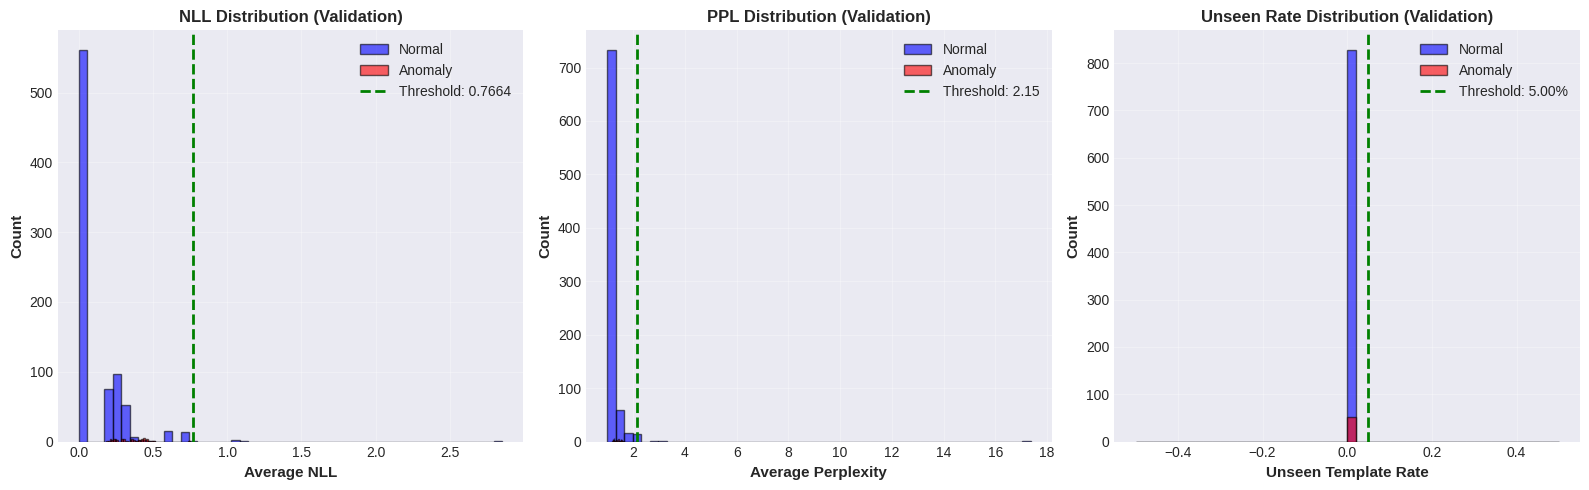

In [33]:
print("="*70)
print("THRESHOLD CALIBRATION ON VALIDATION SET")
print("="*70)

# Compute scores for validation set
val_scores, val_labels_actual = compute_window_scores(model, val_loader, vocab_size, pad_id, device)

# Convert to DataFrame for analysis
val_df = pd.DataFrame(val_scores, columns=['avg_nll', 'avg_ppl', 'unseen_rate'])
val_df['label'] = val_labels_actual

print(f"\nComputed scores for {len(val_df):,} validation windows")

# Separate normal and anomalous windows
normal_df = val_df[val_df['label'] == 0]
anomaly_df = val_df[val_df['label'] == 1]

print(f"\nNormal windows:   {len(normal_df):,}")
print(f"Anomaly windows:  {len(anomaly_df):,}")

# Calibrate thresholds on NORMAL validation windows only
print(f"\n{'='*70}")
print(f"CALIBRATING THRESHOLDS (on normal windows only)")
print(f"{'='*70}")

# NLL threshold: 99.5th percentile
nll_threshold = np.percentile(normal_df['avg_nll'], 99.5)
print(f"\nNLL Threshold (99.5th percentile):  {nll_threshold:.4f}")

# PPL threshold: 99.5th percentile
ppl_threshold = np.percentile(normal_df['avg_ppl'], 99.5)
print(f"PPL Threshold (99.5th percentile):  {ppl_threshold:.2f}")

# Unseen rate threshold: Hard rule at 5%
unseen_threshold = 0.05
print(f"Unseen Rate Threshold (hard rule):  {unseen_threshold:.2%}")

# Statistics on normal windows
print(f"\nNormal Window Statistics:")
print(f"  Avg NLL:        {normal_df['avg_nll'].mean():.4f} ± {normal_df['avg_nll'].std():.4f}")
print(f"  Avg PPL:        {normal_df['avg_ppl'].mean():.2f} ± {normal_df['avg_ppl'].std():.2f}")
print(f"  Avg Unseen:     {normal_df['unseen_rate'].mean():.2%} ± {normal_df['unseen_rate'].std():.2%}")

if len(anomaly_df) > 0:
    print(f"\nAnomaly Window Statistics (for reference):")
    print(f"  Avg NLL:        {anomaly_df['avg_nll'].mean():.4f} ± {anomaly_df['avg_nll'].std():.4f}")
    print(f"  Avg PPL:        {anomaly_df['avg_ppl'].mean():.2f} ± {anomaly_df['avg_ppl'].std():.2f}")
    print(f"  Avg Unseen:     {anomaly_df['unseen_rate'].mean():.2%} ± {anomaly_df['unseen_rate'].std():.2%}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# NLL distribution
ax1 = axes[0]
ax1.hist(normal_df['avg_nll'], bins=50, alpha=0.6, label='Normal', color='blue', edgecolor='black')
if len(anomaly_df) > 0:
    ax1.hist(anomaly_df['avg_nll'], bins=50, alpha=0.6, label='Anomaly', color='red', edgecolor='black')
ax1.axvline(nll_threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold: {nll_threshold:.4f}')
ax1.set_xlabel('Average NLL', fontsize=11, fontweight='bold')
ax1.set_ylabel('Count', fontsize=11, fontweight='bold')
ax1.set_title('NLL Distribution (Validation)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# PPL distribution
ax2 = axes[1]
ax2.hist(normal_df['avg_ppl'], bins=50, alpha=0.6, label='Normal', color='blue', edgecolor='black')
if len(anomaly_df) > 0:
    ax2.hist(anomaly_df['avg_ppl'], bins=50, alpha=0.6, label='Anomaly', color='red', edgecolor='black')
ax2.axvline(ppl_threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold: {ppl_threshold:.2f}')
ax2.set_xlabel('Average Perplexity', fontsize=11, fontweight='bold')
ax2.set_ylabel('Count', fontsize=11, fontweight='bold')
ax2.set_title('PPL Distribution (Validation)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Unseen rate distribution
ax3 = axes[2]
ax3.hist(normal_df['unseen_rate'], bins=50, alpha=0.6, label='Normal', color='blue', edgecolor='black')
if len(anomaly_df) > 0:
    ax3.hist(anomaly_df['unseen_rate'], bins=50, alpha=0.6, label='Anomaly', color='red', edgecolor='black')
ax3.axvline(unseen_threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold: {unseen_threshold:.2%}')
ax3.set_xlabel('Unseen Template Rate', fontsize=11, fontweight='bold')
ax3.set_ylabel('Count', fontsize=11, fontweight='bold')
ax3.set_title('Unseen Rate Distribution (Validation)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPO_ROOT / 'artifacts/metrics/openstack/threshold_calibration.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Saved threshold calibration plot")
plt.show()

print(f"\n{'='*70}\n")

## Apply Thresholds & Evaluate on Test Set

In [34]:
print("="*70)
print("APPLYING THRESHOLDS TO TEST SET")
print("="*70)

# Compute scores for test set
test_scores, test_labels_actual = compute_window_scores(model, test_loader, vocab_size, pad_id, device)

# Convert to DataFrame
test_df = pd.DataFrame(test_scores, columns=['avg_nll', 'avg_ppl', 'unseen_rate'])
test_df['label'] = test_labels_actual

print(f"\nComputed scores for {len(test_df):,} test windows")

# Apply detection rules
# Rule 1: NLL exceeds threshold
test_df['anomaly_nll'] = (test_df['avg_nll'] > nll_threshold).astype(int)

# Rule 2: PPL exceeds threshold
test_df['anomaly_ppl'] = (test_df['avg_ppl'] > ppl_threshold).astype(int)

# Rule 3: Unseen rate exceeds threshold (hard rule)
test_df['anomaly_unseen'] = (test_df['unseen_rate'] > unseen_threshold).astype(int)

# Combined rule: ANY of the above triggers anomaly
test_df['anomaly_combined'] = ((test_df['anomaly_nll'] == 1) | 
                                (test_df['anomaly_ppl'] == 1) | 
                                (test_df['anomaly_unseen'] == 1)).astype(int)

# Compute metrics for each detection method
methods = {
    'NLL-based': 'anomaly_nll',
    'PPL-based': 'anomaly_ppl',
    'Unseen-based': 'anomaly_unseen',
    'Combined (OR)': 'anomaly_combined'
}

results = {}

print(f"\n{'='*70}")
print(f"DETECTION RESULTS")
print(f"{'='*70}")

for method_name, pred_col in methods.items():
    y_true = test_df['label'].values
    y_pred = test_df[pred_col].values
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    results[method_name] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'specificity': specificity,
        'tp': int(tp),
        'fp': int(fp),
        'tn': int(tn),
        'fn': int(fn)
    }
    
    print(f"\n{method_name}:")
    print(f"  Precision:    {precision:.4f}")
    print(f"  Recall:       {recall:.4f}")
    print(f"  F1-Score:     {f1:.4f}")
    print(f"  Accuracy:     {accuracy:.4f}")
    print(f"  Specificity:  {specificity:.4f}")
    print(f"  TP: {tp:,} | FP: {fp:,} | TN: {tn:,} | FN: {fn:,}")

print(f"\n{'='*70}\n")

# Save results
results_path = REPO_ROOT / 'artifacts/metrics/openstack/anomaly_detection_results.json'
results_path.parent.mkdir(parents=True, exist_ok=True)

results_export = {
    'thresholds': {
        'nll_threshold': float(nll_threshold),
        'ppl_threshold': float(ppl_threshold),
        'unseen_rate_threshold': float(unseen_threshold)
    },
    'validation_stats': {
        'normal_count': int(len(normal_df)),
        'anomaly_count': int(len(anomaly_df)),
        'normal_avg_nll': float(normal_df['avg_nll'].mean()),
        'normal_avg_ppl': float(normal_df['avg_ppl'].mean()),
        'normal_avg_unseen': float(normal_df['unseen_rate'].mean())
    },
    'test_results': results
}

with open(results_path, 'w') as f:
    json.dump(results_export, f, indent=2)

print(f"✓ Saved results to: {results_path}\n")

APPLYING THRESHOLDS TO TEST SET


Computing scores:   0%|          | 0/16 [00:00<?, ?it/s]

/home/tpi/anaconda3/envs/log_anomaly/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(



Computed scores for 986 test windows

DETECTION RESULTS

NLL-based:
  Precision:    0.9147
  Recall:       0.6413
  F1-Score:     0.7540
  Accuracy:     0.9219
  Specificity:  0.9863
  TP: 118 | FP: 11 | TN: 791 | FN: 66

PPL-based:
  Precision:    0.9147
  Recall:       0.6413
  F1-Score:     0.7540
  Accuracy:     0.9219
  Specificity:  0.9863
  TP: 118 | FP: 11 | TN: 791 | FN: 66

Unseen-based:
  Precision:    0.0000
  Recall:       0.0000
  F1-Score:     0.0000
  Accuracy:     0.8134
  Specificity:  1.0000
  TP: 0 | FP: 0 | TN: 802 | FN: 184

Combined (OR):
  Precision:    0.9147
  Recall:       0.6413
  F1-Score:     0.7540
  Accuracy:     0.9219
  Specificity:  0.9863
  TP: 118 | FP: 11 | TN: 791 | FN: 66


✓ Saved results to: /home/tpi/distil_shahreyar/artifacts/metrics/openstack/anomaly_detection_results.json



## Diagnostic Analysis: Template Coverage & Positional Entropy

In [35]:
# 1. Template Coverage Analysis
print("="*70)
print("TEMPLATE COVERAGE DIAGNOSTIC")
print("="*70)

def extract_unique_templates(sequences):
    """Extract all unique template IDs from sequences"""
    unique = set()
    for seq in sequences:
        unique.update(seq)
    return unique

# Read training data to get train templates
train_sequences = []
train_table = pq.read_table((REPO_ROOT / data_cfg['train_file']).resolve(), columns=['templates'])
for seq in train_table.column(0).to_pylist():
    if seq and len(seq) > 1:
        train_sequences.append([int(x) for x in seq])

train_templates = extract_unique_templates(train_sequences)
val_templates = extract_unique_templates(val_sequences)
test_templates = extract_unique_templates(test_sequences)

# Calculate unseen templates
val_unseen = val_templates - train_templates
test_unseen = test_templates - train_templates

# Calculate coverage metrics
val_coverage = (len(val_templates) - len(val_unseen)) / len(val_templates) * 100 if val_templates else 0
test_coverage = (len(test_templates) - len(test_unseen)) / len(test_templates) * 100 if test_templates else 0

print(f"\nTemplate Statistics:")
print(f"  Train unique templates:     {len(train_templates):,}")
print(f"  Val unique templates:       {len(val_templates):,}")
print(f"  Test unique templates:      {len(test_templates):,}")

print(f"\nUnseen Templates (not in train):")
print(f"  Val unseen templates:       {len(val_unseen):,} ({100 - val_coverage:.2f}%)")
print(f"  Test unseen templates:      {len(test_unseen):,} ({100 - test_coverage:.2f}%)")

print(f"\nTemplate Coverage:")
print(f"  Val coverage:               {val_coverage:.2f}%")
print(f"  Test coverage:              {test_coverage:.2f}%")

if val_unseen:
    print(f"\nSample Val Unseen Template IDs (first 20): {sorted(list(val_unseen))[:20]}")
if test_unseen:
    print(f"Sample Test Unseen Template IDs (first 20): {sorted(list(test_unseen))[:20]}")

# Analysis
print(f"\n{'='*70}")
if val_coverage > 95 and test_coverage > 95:
    print("✓ EXCELLENT: High coverage (>95%) - low perplexity is justified")
elif val_coverage > 85 and test_coverage > 85:
    print("✓ GOOD: Reasonable coverage (>85%) - perplexity reflects seen templates")
else:
    print("⚠ MODERATE: Some unseen templates - may want to:")
    print("  - Increase Drain3 similarity (try 0.45 instead of 0.4)")
    print("  - Refine template normalization")
    print("  - Consider expanding training data")
print(f"{'='*70}\n")

TEMPLATE COVERAGE DIAGNOSTIC

Template Statistics:
  Train unique templates:     81
  Val unique templates:       39
  Test unique templates:      48

Unseen Templates (not in train):
  Val unseen templates:       1 (2.56%)
  Test unseen templates:      3 (6.25%)

Template Coverage:
  Val coverage:               97.44%
  Test coverage:              93.75%

Sample Val Unseen Template IDs (first 20): [147]
Sample Test Unseen Template IDs (first 20): [147, 149, 156]

✓ GOOD: Reasonable coverage (>85%) - perplexity reflects seen templates



POSITIONAL ENTROPY DIAGNOSTIC

Computing position-wise losses on validation set...


Position Analysis:   0%|          | 0/14 [00:00<?, ?it/s]

/home/tpi/anaconda3/envs/log_anomaly/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(



Position-wise Statistics (first 20 positions):
 position  avg_loss  perplexity  std_loss  count
        0  0.088453    1.092483  0.580323    879
        1  0.680172    1.974216  0.818914    465
        2  0.091666    1.095999  0.450849    465
        3  0.318250    1.374720  0.718505    465
        4  0.207304    1.230356  0.579791    465
        5  0.272738    1.313556  0.625488    258
        6  0.067172    1.069479  0.328437    258
        7  0.082697    1.086212  0.479026    258
        8  0.085930    1.089730  0.389405    258
        9  0.064324    1.066438  0.299203    258
       10  0.058180    1.059906  0.225714    258
       11  0.601183    1.824275  1.306802     51
       12  0.329904    1.390835  0.742133     51
       13  0.343059    1.409253  0.575580     51
       14  0.273577    1.314659  0.813113     51
       15  0.324746    1.383679  0.735023     51
       16  0.394875    1.484199  0.736163     51
       17  0.282734    1.326752  0.585817     51
       18  0.246645  

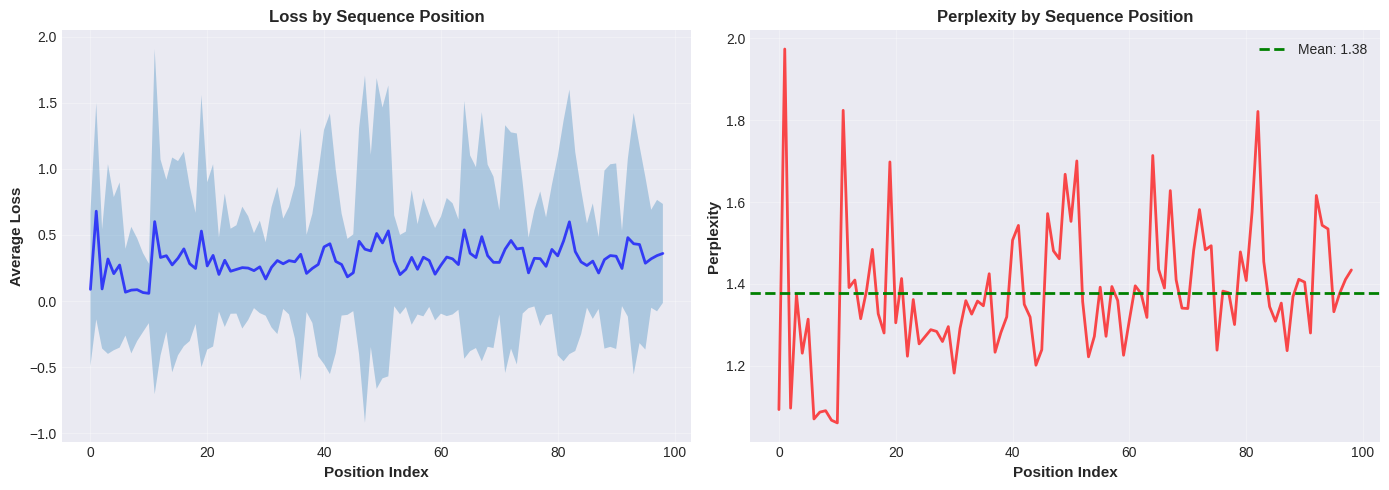



✓ Saved diagnostic results to: /home/tpi/distil_shahreyar/artifacts/metrics/openstack/anomaly_diagnostics.json



In [36]:
# 2. Positional Entropy Analysis
print("="*70)
print("POSITIONAL ENTROPY DIAGNOSTIC")
print("="*70)

# Collect loss per position on validation set
position_losses = defaultdict(list)
position_counts = defaultdict(int)

print("\nComputing position-wise losses on validation set...")
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Position Analysis", leave=False):
        input_ids = batch['input_ids'].to(device)
        target_ids = batch['target_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        logits = model(input_ids, attention_mask)
        
        # Compute loss per position
        for i in range(input_ids.size(1)):
            mask = attention_mask[:, i] == 1
            if mask.sum() == 0:
                continue
                
            pos_logits = logits[mask, i, :]
            pos_targets = target_ids[mask, i]
            
            # Filter out padding targets
            valid = pos_targets != pad_id
            if valid.sum() == 0:
                continue
                
            pos_loss = F.cross_entropy(pos_logits[valid], pos_targets[valid], reduction='none')
            position_losses[i].extend(pos_loss.cpu().tolist())
            position_counts[i] += valid.sum().item()

# Calculate statistics per position
position_stats = []
for pos in sorted(position_losses.keys()):
    losses = position_losses[pos]
    if len(losses) > 0:
        avg_loss = np.mean(losses)
        avg_ppl = np.exp(min(avg_loss, 50))
        std_loss = np.std(losses)
        position_stats.append({
            'position': pos,
            'avg_loss': avg_loss,
            'perplexity': avg_ppl,
            'std_loss': std_loss,
            'count': position_counts[pos]
        })

pos_df = pd.DataFrame(position_stats)

print(f"\nPosition-wise Statistics (first 20 positions):")
print(pos_df.head(20).to_string(index=False))

if len(pos_df) > 20:
    print(f"\n... (showing first 20 of {len(pos_df)} positions)")
    print(f"\nLast 10 positions:")
    print(pos_df.tail(10).to_string(index=False))

# Identify high-entropy positions
high_entropy_threshold = pos_df['perplexity'].quantile(0.90)
high_entropy_positions = pos_df[pos_df['perplexity'] > high_entropy_threshold]

print(f"\n{'='*70}")
print(f"High-Entropy Positions (top 10%):")
print(f"{'='*70}")
if len(high_entropy_positions) > 0:
    print(high_entropy_positions.to_string(index=False))
    print(f"\nAnalysis: Positions {high_entropy_positions['position'].min()}-{high_entropy_positions['position'].max()} show elevated perplexity")
    print("  This may indicate:")
    print("  - Boundary effects (start/end of sequences)")
    print("  - Complex transition patterns at specific positions")
    print("  - Insufficient training data for certain sequence lengths")
else:
    print("✓ No significant high-entropy positions detected")
    print("  Model has uniform confidence across sequence positions")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss by position
ax1 = axes[0]
ax1.plot(pos_df['position'], pos_df['avg_loss'], 'b-', linewidth=2, alpha=0.7)
ax1.fill_between(pos_df['position'], 
                  pos_df['avg_loss'] - pos_df['std_loss'],
                  pos_df['avg_loss'] + pos_df['std_loss'],
                  alpha=0.3)
ax1.set_xlabel('Position Index', fontsize=11, fontweight='bold')
ax1.set_ylabel('Average Loss', fontsize=11, fontweight='bold')
ax1.set_title('Loss by Sequence Position', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Perplexity by position
ax2 = axes[1]
ax2.plot(pos_df['position'], pos_df['perplexity'], 'r-', linewidth=2, alpha=0.7)
ax2.axhline(y=pos_df['perplexity'].mean(), color='green', linestyle='--', 
            label=f'Mean: {pos_df["perplexity"].mean():.2f}', linewidth=2)
ax2.set_xlabel('Position Index', fontsize=11, fontweight='bold')
ax2.set_ylabel('Perplexity', fontsize=11, fontweight='bold')
ax2.set_title('Perplexity by Sequence Position', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPO_ROOT / 'artifacts/metrics/openstack/positional_entropy_diagnostic.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Saved positional entropy plot")
plt.show()

print(f"\n{'='*70}\n")

# Save diagnostic results
diagnostic_results = {
    'template_coverage': {
        'train_unique_templates': int(len(train_templates)),
        'val_unique_templates': int(len(val_templates)),
        'test_unique_templates': int(len(test_templates)),
        'val_unseen_templates': int(len(val_unseen)),
        'test_unseen_templates': int(len(test_unseen)),
        'val_coverage_pct': float(val_coverage),
        'test_coverage_pct': float(test_coverage)
    },
    'positional_entropy': {
        'total_positions_analyzed': len(pos_df),
        'avg_perplexity_across_positions': float(pos_df['perplexity'].mean()),
        'std_perplexity_across_positions': float(pos_df['perplexity'].std()),
        'min_perplexity_position': int(pos_df.loc[pos_df['perplexity'].idxmin(), 'position']),
        'max_perplexity_position': int(pos_df.loc[pos_df['perplexity'].idxmax(), 'position']),
        'min_perplexity_value': float(pos_df['perplexity'].min()),
        'max_perplexity_value': float(pos_df['perplexity'].max()),
        'high_entropy_positions': high_entropy_positions['position'].tolist() if len(high_entropy_positions) > 0 else []
    }
}

diagnostic_path = REPO_ROOT / 'artifacts/metrics/openstack/anomaly_diagnostics.json'
with open(diagnostic_path, 'w') as f:
    json.dump(diagnostic_results, f, indent=2)

print(f"✓ Saved diagnostic results to: {diagnostic_path}\n")

## Summary & Recommendations

In [37]:
print("="*70)
print("SUMMARY & RECOMMENDATIONS")
print("="*70)

print("\n📊 CALIBRATED THRESHOLDS:")
print(f"  NLL Threshold:        {nll_threshold:.4f} (99.5th percentile of normal)")
print(f"  PPL Threshold:        {ppl_threshold:.2f} (99.5th percentile of normal)")
print(f"  Unseen Rate Threshold: {unseen_threshold:.2%} (hard rule)")

print("\n🎯 DETECTION PERFORMANCE (Test Set):")
best_method = max(results.items(), key=lambda x: x[1]['f1'])
print(f"  Best Method: {best_method[0]}")
print(f"    F1-Score:  {best_method[1]['f1']:.4f}")
print(f"    Precision: {best_method[1]['precision']:.4f}")
print(f"    Recall:    {best_method[1]['recall']:.4f}")

print("\n🔍 DIAGNOSTIC INSIGHTS:")
print(f"  Template Coverage:")
print(f"    Val:  {val_coverage:.2f}% ({len(val_unseen):,} unseen)")
print(f"    Test: {test_coverage:.2f}% ({len(test_unseen):,} unseen)")
print(f"  Positional Entropy:")
print(f"    Avg PPL across positions: {pos_df['perplexity'].mean():.2f}")
print(f"    High-entropy positions:   {len(high_entropy_positions)}")

print("\n💡 RECOMMENDATIONS:")

# Recommendation 1: Template coverage
if val_coverage < 95 or test_coverage < 95:
    print("\n  1. IMPROVE TEMPLATE COVERAGE:")
    print("     ⚠ Some templates are unseen in training")
    print("     → Try Drain3 similarity 0.45 (currently 0.4)")
    print("     → Review template normalization rules")
    print("     → Consider expanding training data")
else:
    print("\n  1. ✓ TEMPLATE COVERAGE: Excellent (>95%)")

# Recommendation 2: Model performance
if best_method[1]['f1'] < 0.8:
    print("\n  2. IMPROVE MODEL PERFORMANCE:")
    print("     → Train longer with non-zero min LR (cosine floor ~1e-5)")
    print("     → Set early stopping patience to 2-3 epochs")
    print("     → If val wobbles, increase dropout to 0.15")
else:
    print("\n  2. ✓ MODEL PERFORMANCE: Good F1-score")

# Recommendation 3: Threshold tuning
print("\n  3. THRESHOLD TUNING:")
print("     → Current: 99.5th percentile (conservative)")
print("     → For higher recall: Use 99.0th or 98.0th percentile")
print("     → For higher precision: Use 99.9th percentile")
print("     → Monitor false positive rate in production")

# Recommendation 4: Production deployment
print("\n  4. PRODUCTION DEPLOYMENT:")
print("     ✓ Save best.pt + template_vocab.json")
print("     ✓ Use calibrated thresholds from this notebook")
print("     ✓ Monitor drift: Recalibrate if normal score distribution shifts")
print("     ✓ Log flagged windows for review and model improvement")

print(f"\n{'='*70}")
print("📁 OUTPUT FILES:")
print(f"{'='*70}")
print(f"  Thresholds & Results:")
print(f"    {results_path}")
print(f"  Diagnostics:")
print(f"    {diagnostic_path}")
print(f"  Visualizations:")
print(f"    {REPO_ROOT / 'artifacts/metrics/openstack/threshold_calibration.png'}")
print(f"    {REPO_ROOT / 'artifacts/metrics/openstack/positional_entropy_diagnostic.png'}")
print(f"\n✅ Anomaly detection pipeline complete!\n")

SUMMARY & RECOMMENDATIONS

📊 CALIBRATED THRESHOLDS:
  NLL Threshold:        0.7664 (99.5th percentile of normal)
  PPL Threshold:        2.15 (99.5th percentile of normal)
  Unseen Rate Threshold: 5.00% (hard rule)

🎯 DETECTION PERFORMANCE (Test Set):
  Best Method: NLL-based
    F1-Score:  0.7540
    Precision: 0.9147
    Recall:    0.6413

🔍 DIAGNOSTIC INSIGHTS:
  Template Coverage:
    Val:  97.44% (1 unseen)
    Test: 93.75% (3 unseen)
  Positional Entropy:
    Avg PPL across positions: 1.38
    High-entropy positions:   10

💡 RECOMMENDATIONS:

  1. IMPROVE TEMPLATE COVERAGE:
     ⚠ Some templates are unseen in training
     → Try Drain3 similarity 0.45 (currently 0.4)
     → Review template normalization rules
     → Consider expanding training data

  2. IMPROVE MODEL PERFORMANCE:
     → Train longer with non-zero min LR (cosine floor ~1e-5)
     → Set early stopping patience to 2-3 epochs
     → If val wobbles, increase dropout to 0.15

  3. THRESHOLD TUNING:
     → Current: 99.